# Test Notebook

**Simple Execution** is the first test, where I manually instantiate all the necessary classes and perform a non-automatic computation.

**Multi-Round Execution** is the automatic computation of the algorithm.

In [1]:
import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


# Multi Rounds

In [20]:
num_workers = 4
num_rounds = 20

m = -2.9
c = 1.1

In [21]:
dataset_X = np.linspace(0, 10, 1000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(30)

dataset_X = dataset_X.reshape(-1,1)

In [22]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [23]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [24]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [25]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [26]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))
    

------ROUND 1------
Mean squared error: 35.009
Coefficient of determinaton: 0.644 

------ROUND 2------
Mean squared error: 34.392
Coefficient of determinaton: 0.650 

------ROUND 3------
Mean squared error: 34.901
Coefficient of determinaton: 0.645 

------ROUND 4------
Mean squared error: 35.064
Coefficient of determinaton: 0.643 

------ROUND 5------
Mean squared error: 34.852
Coefficient of determinaton: 0.646 

------ROUND 6------
Mean squared error: 34.574
Coefficient of determinaton: 0.648 

------ROUND 7------
Mean squared error: 34.576
Coefficient of determinaton: 0.648 

------ROUND 8------
Mean squared error: 34.437
Coefficient of determinaton: 0.650 

------ROUND 9------
Mean squared error: 34.281
Coefficient of determinaton: 0.651 

------ROUND 10------
Mean squared error: 34.239
Coefficient of determinaton: 0.652 

------ROUND 11------
Mean squared error: 34.126
Coefficient of determinaton: 0.653 

------ROUND 12------
Mean squared error: 34.043
Coefficient of determinato

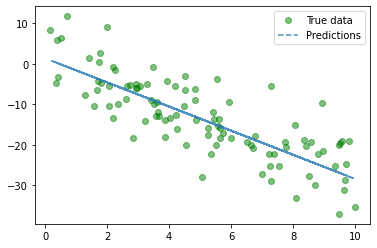

In [27]:
plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')
plt.show()

<Figure size 720x360 with 0 Axes>

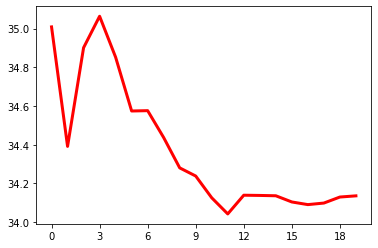

In [28]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)

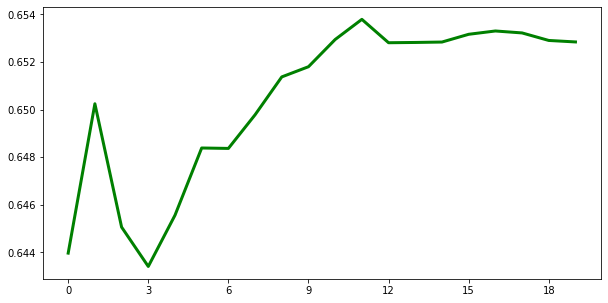

In [29]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.draw()

## Evaluating only the single worker

In [30]:
worker_list = []
worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)


error_single = []
score_single = []

for i in range(0, num_rounds):
    
    worker_list[0].train(X = train_list_X[i*num_workers] , y = train_list_y[i*num_workers])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error_single.append(mean_squared_error(test_y, pred_server))
    score_single.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 35.379
Coefficient of determinaton: 0.640 

------ROUND 2------
Mean squared error: 35.098
Coefficient of determinaton: 0.643 

------ROUND 3------
Mean squared error: 34.311
Coefficient of determinaton: 0.651 

------ROUND 4------
Mean squared error: 35.930
Coefficient of determinaton: 0.635 

------ROUND 5------
Mean squared error: 35.449
Coefficient of determinaton: 0.639 

------ROUND 6------
Mean squared error: 35.484
Coefficient of determinaton: 0.639 

------ROUND 7------
Mean squared error: 34.853
Coefficient of determinaton: 0.646 

------ROUND 8------
Mean squared error: 34.805
Coefficient of determinaton: 0.646 

------ROUND 9------
Mean squared error: 34.425
Coefficient of determinaton: 0.650 

------ROUND 10------
Mean squared error: 34.208
Coefficient of determinaton: 0.652 

------ROUND 11------
Mean squared error: 34.128
Coefficient of determinaton: 0.653 

------ROUND 12------
Mean squared error: 34.074
Coefficient of determinato

<Figure size 720x360 with 0 Axes>

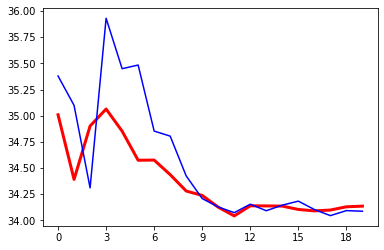

In [31]:
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

figure(figsize=(10,5))

x = np.arange(num_rounds)

ax = plt.figure().gca()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x, error, color='red', linewidth=3)
plt.plot(x, error_single, color='blue')

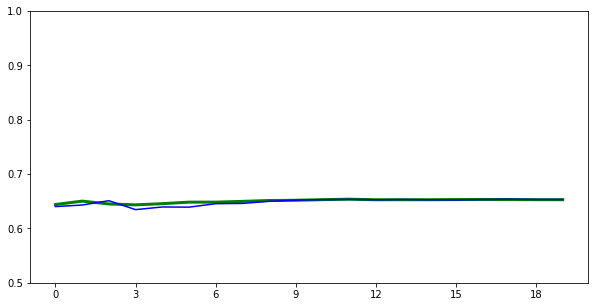

In [32]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)
plt.plot(x, score_single, color='blue')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim([0.5,1])

plt.draw()

In [33]:
worker_list = []
worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)


error_single = []
score_single = []


for i in range(0, num_rounds):
    
    worker_list[0].model.fit(X = train_list_X[i*num_workers] , y = train_list_y[i*num_workers])
    
    pred_server = worker_list[0].model.predict(test_X)
    print('------ROUND {}------'.format(i))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error_single.append(mean_squared_error(test_y, pred_server))
    score_single.append(r2_score(test_y, pred_server))

------ROUND 0------
Mean squared error: 35.379
Coefficient of determinaton: 0.640 

------ROUND 1------
Mean squared error: 44.086
Coefficient of determinaton: 0.552 

------ROUND 2------
Mean squared error: 40.809
Coefficient of determinaton: 0.585 

------ROUND 3------
Mean squared error: 54.822
Coefficient of determinaton: 0.442 

------ROUND 4------
Mean squared error: 44.155
Coefficient of determinaton: 0.551 

------ROUND 5------
Mean squared error: 35.703
Coefficient of determinaton: 0.637 

------ROUND 6------
Mean squared error: 35.367
Coefficient of determinaton: 0.640 

------ROUND 7------
Mean squared error: 34.590
Coefficient of determinaton: 0.648 

------ROUND 8------
Mean squared error: 37.835
Coefficient of determinaton: 0.615 

------ROUND 9------
Mean squared error: 36.624
Coefficient of determinaton: 0.628 

------ROUND 10------
Mean squared error: 46.384
Coefficient of determinaton: 0.528 

------ROUND 11------
Mean squared error: 35.221
Coefficient of determinaton

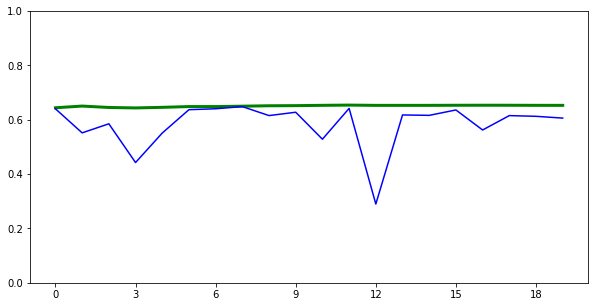

In [36]:
figure(figsize=(10,5))

x = np.arange(num_rounds)

plt.plot(x, score, color='green', linewidth=3)
plt.plot(x, score_single, color='blue')

ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim([0,1])

plt.draw()